# Grupo ZAP: Data Science Challenge

## Desafio - Quanto custa?
O objetivo é Desenvolver uma maneira automática de estimar um preço de venda para os apartamentos no dataset de teste.


### 1. Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
import json
%matplotlib inline
from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from collections import Counter

### 2. Importando dados

In [2]:
#abrindo arquivo json
with open('train.json','r',encoding="utf8") as f:
    data = [json.loads(line) for line in f]

In [3]:
#transformando o arquivo em dataframe
from pandas.io.json import json_normalize
df = pd.DataFrame.from_dict(json_normalize(data), orient='columns')

In [4]:
df

,address.city,address.country,address.district,address.geoLocation.location.lat,address.geoLocation.location.lon,address.geoLocation.precision,address.locationId,address.neighborhood,address.state,address.street,...,pricingInfos.rentalTotalPrice,pricingInfos.yearlyIptu,publicationType,publisherId,suites,title,totalAreas,unitTypes,updatedAt,usableAreas
0,São Paulo,BR,,-23.612923,-46.614222,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da...,Jardim da Saúde,São Paulo,Rua Juvenal Galeno,...,NaN,NaN,STANDARD,f4603b2b52,1.0,PRÓXIMO A AVENIDA PRESIDENTE TANCREDO NEVES,388.0,TWO_STORY_HOUSE,2018-12-06T19:27:12.623Z,388.0
1,São Paulo,BR,,-23.643962,-46.593475,RANGE_INTERPOLATED,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Liviero,Vila Santa Teresa (Zona Sul),São Paulo,Rua Juruaba,...,NaN,NaN,STANDARD,f4603b2b52,1.0,PRÓXIMO A FACULDADE UNIP CAMPUS ANCHIETA,129.0,HOME,2018-12-12T13:17:23.547Z,129.0
2,São Paulo,,,-23.568559,-46.647452,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Centro>Cerqueira C...,Bela Vista,São Paulo,Avenida Paulista,...,29829.0,4040.0,STANDARD,501f6d5e94,0.0,Excelente Conjunto Comercial na Av. Paulista,NaN,COMMERCIAL_PROPERTY,NaN,396.0
3,São Paulo,,,-23.598023,-46.682781,RANGE_INTERPOLATED,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Olimpia,Vila Olímpia,São Paulo,Rua Alvorada,...,NaN,1610.0,STANDARD,527c7b0cc0,1.0,"Apartamento com 80m², 2 vagas próximo ao Parqu...",80.0,APARTMENT,2018-11-08T16:38:35.434Z,80.0
4,São Paulo,,,-23.582497,-46.653027,RANGE_INTERPOLATED,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Paraiso,Paraíso,São Paulo,Rua Curitiba,...,NaN,18900.0,STANDARD,527c7b0cc0,4.0,"Apartamento 332m², 4 suítes à venda próximo ao...",332.0,APARTMENT,2018-12-14T18:06:55.140Z,3322.0
5,São Paulo,BR,,-23.603692,-46.673550,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Moema,Vila Uberabinha,São Paulo,Rua Pintassilgo,...,2450.0,87.0,PREMIUM,ca5d5b66fe,1.0,Flat em Moema para Locação,45.0,FLAT,2018-12-14T07:33:22.144Z,45.0
6,São Paulo,,,-23.561318,-46.686355,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Zona Oeste>Pinheiros,Pinheiros,São Paulo,Rua Mateus Grou,...,NaN,489.0,STANDARD,eab052c04f,0.0,APARTAMENTO EM PINHEIROS!!!,0.0,APARTMENT,2018-11-08T12:57:03.132Z,94.0
7,São Paulo,,,-23.578943,-46.556802,GEOMETRIC_CENTER,BR>Sao Paulo>NULL>Sao Paulo>Zona Leste>Vila Sa...,Vila Santa Clara,São Paulo,Rua Dona Luísa de Paiva Dias,...,NaN,0.0,STANDARD,3ac7c1f85f,1.0,Oportunidade,92.0,CONDOMINIUM,2019-01-02T13:39:26.939Z,110.0
8,São Paulo,,,-23.561594,-46.540996,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Zona Leste>Vila Fo...,Vila Formosa,São Paulo,Rua Oswaldo Arouca,...,NaN,5600.0,STANDARD,dda60c7666,0.0,"OTIMO PREDIO COMERCIAL, DE ESQUINA E EM RUA MO...",0.0,SHED_DEPOSIT_WAREHOUSE,2018-11-08T12:54:37.220Z,590.0
9,São Paulo,,,-23.568103,-46.628405,RANGE_INTERPOLATED,BR>Sao Paulo>NULL>Sao Paulo>Centro>Aclimacao,Aclimação,São Paulo,Rua Almeida Torres,...,NaN,0.0,PREMIUM,a9891875dd,3.0,Apartamento para venda com 141 metros quadrado...,141.0,APARTMENT,2019-01-09T18:48:43.900Z,141.0


### 3.Analisando os dados

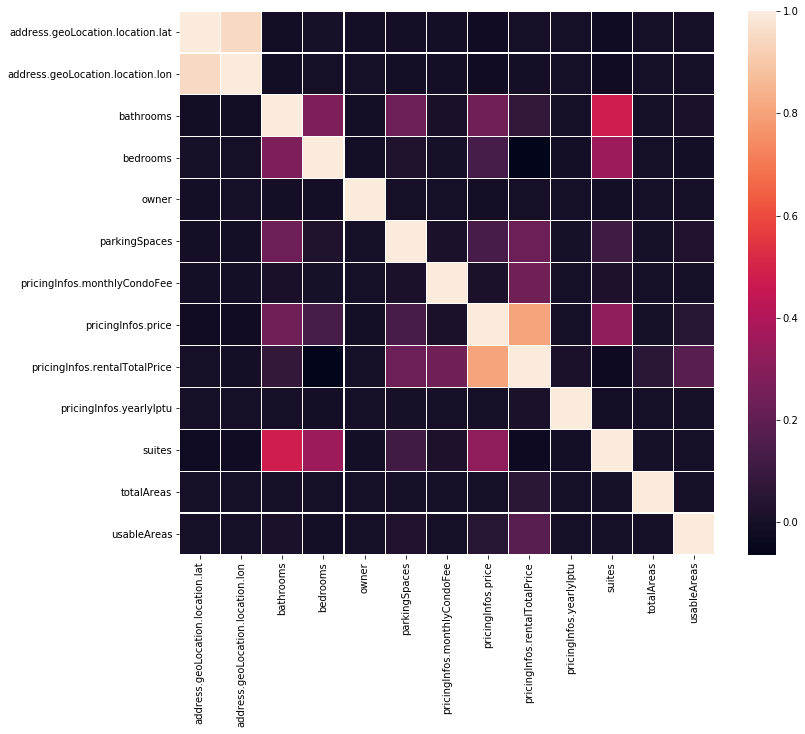

In [5]:
#Matrix de correlação e mapa de calor
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),linewidths=0.1)

Na matriz de correlação acima tem-se que a variável 'pricingInfos.price' se correlaciona melhor com o preço dos alugueis em seguida com o número de suítes, banheiros, quartos e vagas na garagem. Infelizmente os dados sobre os preços dos alugueis são os que estão mais faltando, conforme a informação a seguir: 

In [6]:
#verificando dados faltando por coluna
df.isnull().sum()

address.city                             0
address.country                          0
address.district                         0
address.geoLocation.location.lat        11
address.geoLocation.location.lon        11
address.geoLocation.precision           11
address.locationId                       0
address.neighborhood                     0
address.state                            0
address.street                           0
address.streetNumber                     0
address.unitNumber                       0
address.zipCode                          0
address.zone                             0
bathrooms                              913
bedrooms                              3019
createdAt                                0
description                              0
id                                       0
images                                   0
listingStatus                            0
owner                                    0
parkingSpaces                         4425
pricingInfo

In [7]:
df['address.state'].value_counts()

São Paulo         133714
SP                   246
                       3
Santa Catarina         1
Name: address.state, dtype: int64

In [8]:
df['listingStatus'].value_counts()

ACTIVE    133964
Name: listingStatus, dtype: int64

### 4.Retirando variáveis

Algumas variáveis serão desconsideradas na análise pois não apresentam importância para a previsão dos preços como a coluna 'images' ou apresentam muitos dados faltando como 'pricingInfos.rentalTotalPrice' 

In [9]:
#retirando a unica linha com o estado de SC antes de retirar a coluna Estado
df.drop(df[(df['address.state']=='Santa Catarina') ].index, axis=0, inplace=True)

In [10]:
df.drop(['publicationType','id','pricingInfos.rentalTotalPrice','address.state','address.zone','address.city','address.streetNumber','address.geoLocation.location.lat','address.geoLocation.location.lon','address.country','address.district','address.locationId','address.unitNumber','address.zipCode','createdAt','description','updatedAt',
            'images','listingStatus','owner','pricingInfos.businessType','pricingInfos.period','publisherId','title'],axis=1,inplace=True)

In [11]:
df.head()

,address.geoLocation.precision,address.neighborhood,address.street,bathrooms,bedrooms,parkingSpaces,pricingInfos.monthlyCondoFee,pricingInfos.price,pricingInfos.yearlyIptu,suites,totalAreas,unitTypes,usableAreas
0,ROOFTOP,Jardim da Saúde,Rua Juvenal Galeno,3.0,4.0,6.0,NaN,700000,NaN,1.0,388.0,TWO_STORY_HOUSE,388.0
1,RANGE_INTERPOLATED,Vila Santa Teresa (Zona Sul),Rua Juruaba,2.0,3.0,2.0,NaN,336000,NaN,1.0,129.0,HOME,129.0
2,ROOFTOP,Bela Vista,Avenida Paulista,4.0,0.0,5.0,4900.0,24929,4040.0,0.0,NaN,COMMERCIAL_PROPERTY,396.0
3,RANGE_INTERPOLATED,Vila Olímpia,Rua Alvorada,2.0,3.0,2.0,686.0,739643,1610.0,1.0,80.0,APARTMENT,80.0
4,RANGE_INTERPOLATED,Paraíso,Rua Curitiba,5.0,4.0,5.0,6230.0,7520099,18900.0,4.0,332.0,APARTMENT,3322.0


### 5.Identificando outliers e as relação das variáveis numéricas com o preço de venda dos imóveis (Price)

Outliers são pontos que se encontram muito fora da média dos dados. Assim se considerados na modelagem do algoritmo podem atrapalhar os resultados a serem obtidos.
Neste ponto do projeto foram analisados os outliers de cada uma das variáveis numéricas para eliminação destes pontos com valores exagerados. Na mesma análise aproveitou-se para compreender a relação entre essas características numericas como numero de banheiros e quartos com a variável Price (preço de venda dos imóveis) que é o foco deste projeto.

#### 5.1 PricingInfos.price

In [12]:
df['pricingInfos.price'].describe()

count    1.339630e+05
mean     6.637491e+05
std      1.317737e+06
min      7.000000e+01
25%      1.750000e+05
50%      3.710000e+05
75%      7.000000e+05
max      8.400000e+07
Name: pricingInfos.price, dtype: float64

C:\Users\Bruno\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


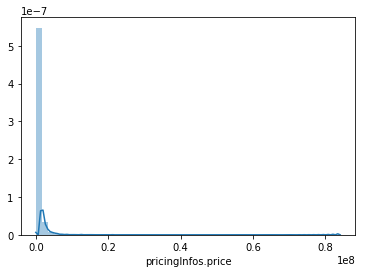

In [13]:
sns.distplot(df['pricingInfos.price'])

Pelo histograma acima tem-se que a distribuição está muito irregular, existem outliers que irão atrapalhar a modelagem dos dados. Assim, vamos encontrar o intervalo interqualtil e retirar os pontos que estão fora deste intervalo.

In [14]:
sort=sorted(df['pricingInfos.price'])
q1, q3= np.percentile(sort,[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)
upper_bound

1487500.0

Limitando o valor máximo de 'pricingInfos.price' para 1.487.500.0 e minnimo para 40.000

In [15]:
df.drop(df[df['pricingInfos.price']>1487500].index, axis=0, inplace=True)
df.drop(df[df['pricingInfos.price']<40000].index, axis=0, inplace=True)

C:\Users\Bruno\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


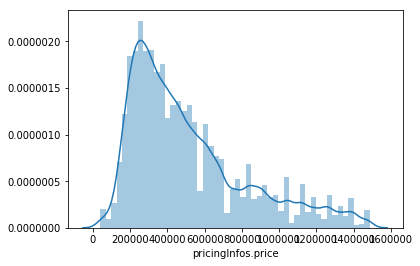

In [16]:
sns.distplot(df['pricingInfos.price'])

Pelo gráfico acima é possível notar uma melhor distribuição dos dados desconsiderando os outliers.


#### 5.2 bathrooms

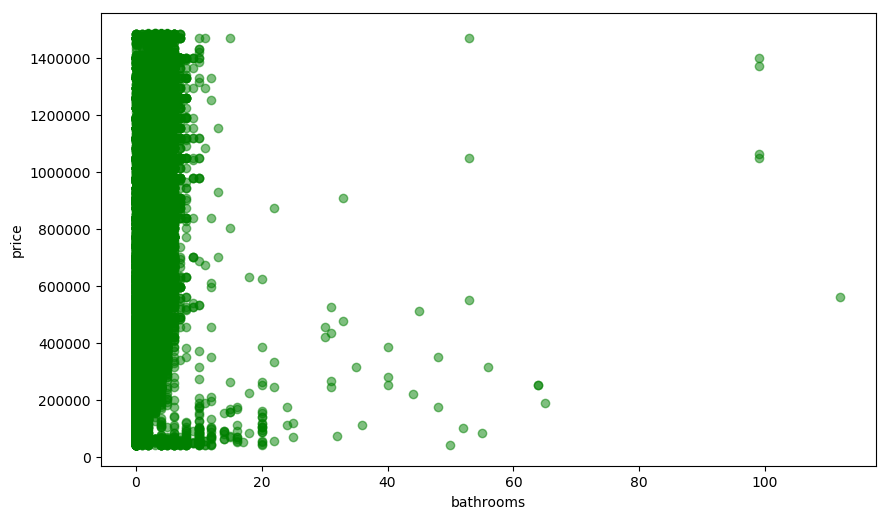

In [17]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['bathrooms'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('bathrooms')
plt.ylabel('price')
plt.show()

In [18]:
df['bathrooms'].describe()


count    92879.000000
mean         2.157915
std          1.772375
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        112.000000
Name: bathrooms, dtype: float64

Pelo gráfico acima pode-se obervar imóveis com quantidade de banheiros acima de 60, ou seja, outliers. Como a quantidade de banheiros são números inteiros é interessante analisar a relação entre **Price** e **bathrooms** por meio de boxplot:

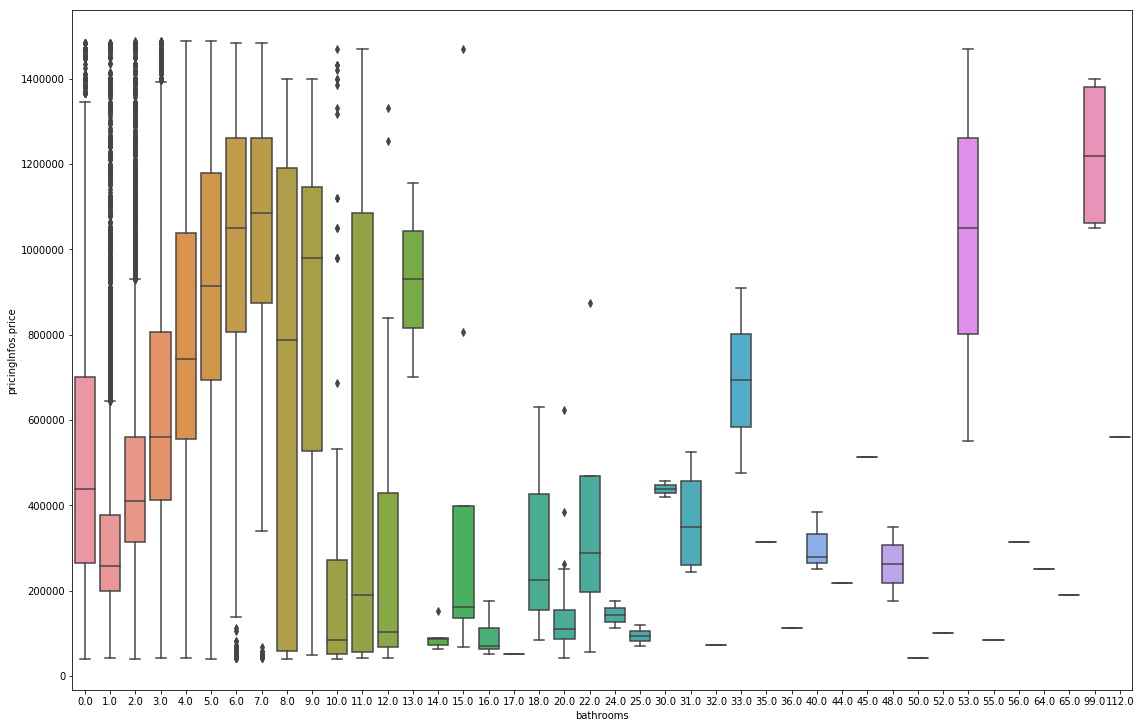

In [19]:
fig=plt.figure(figsize=(19,12.5))
sns.boxplot(x=df['bathrooms'], y=df['pricingInfos.price'])

Observa-se no gráfico que a média de preço dos imóveis cresce à medida que aumenta o número de banheiros para até 7 banheiros, a partir disso a relação se distorce. Assim sendo optou-se por cortar os dados entre a quantidade de 1 a 7 banheiros:

In [20]:
df.drop(df[df['bathrooms']<1].index, axis=0, inplace=True)
df.drop(df[df['bathrooms']>7].index, axis=0, inplace=True)

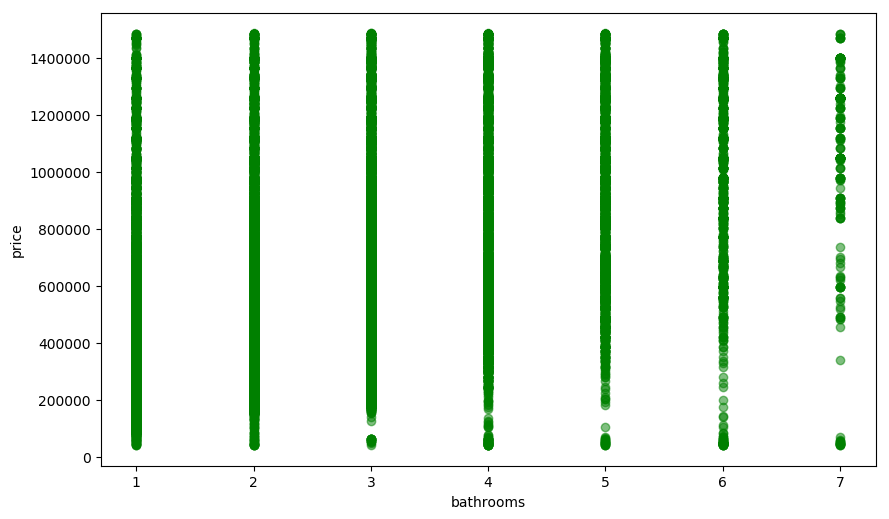

In [21]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['bathrooms'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('bathrooms')
plt.ylabel('price')
plt.show()

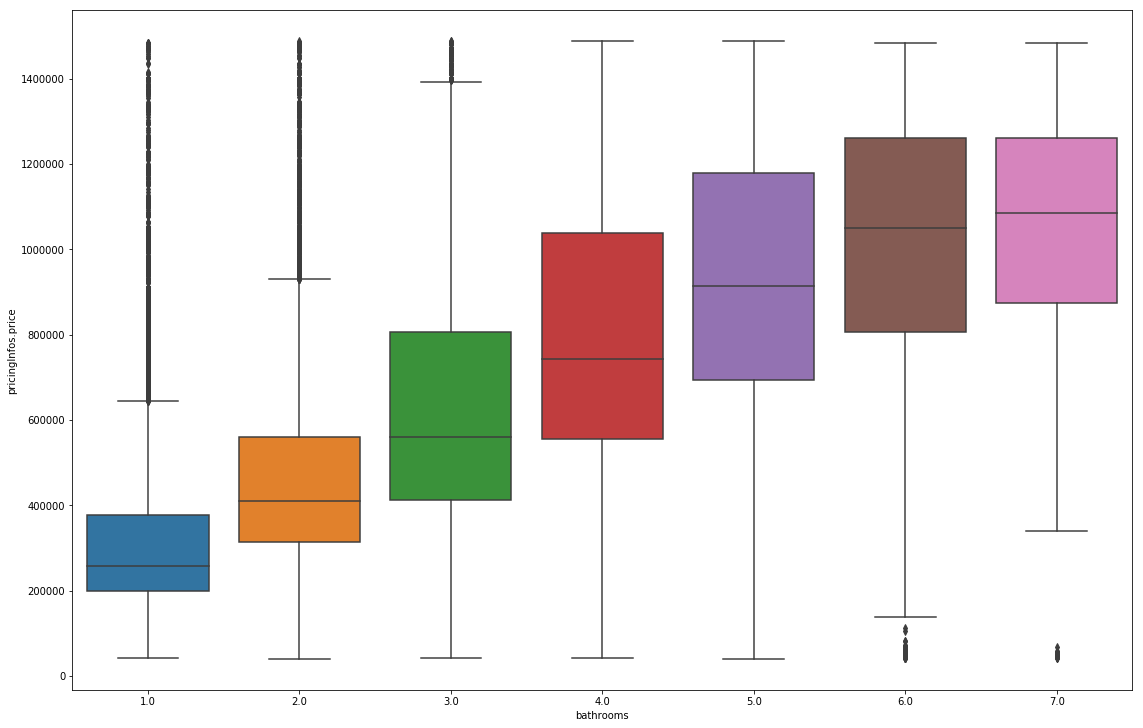

In [22]:
fig=plt.figure(figsize=(19,12.5))
sns.boxplot(x=df['bathrooms'], y=df['pricingInfos.price'])

#### 5.3 Bedrooms

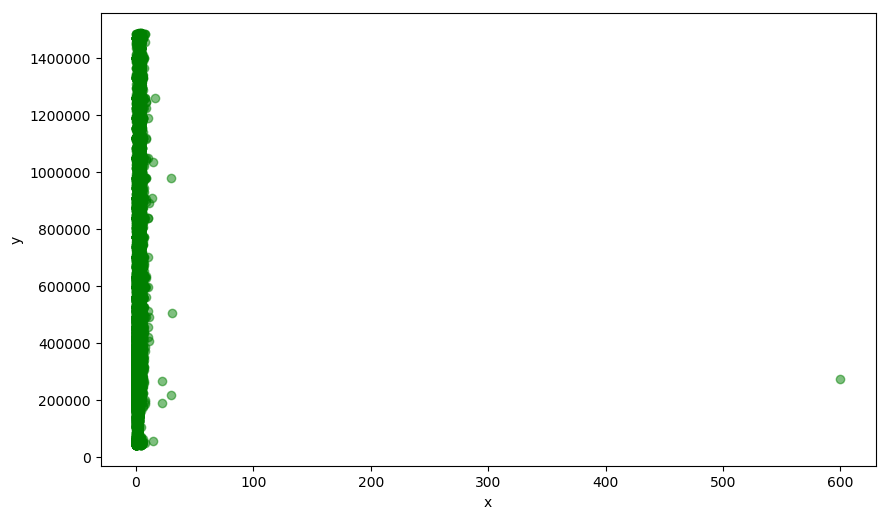

In [23]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['bedrooms'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

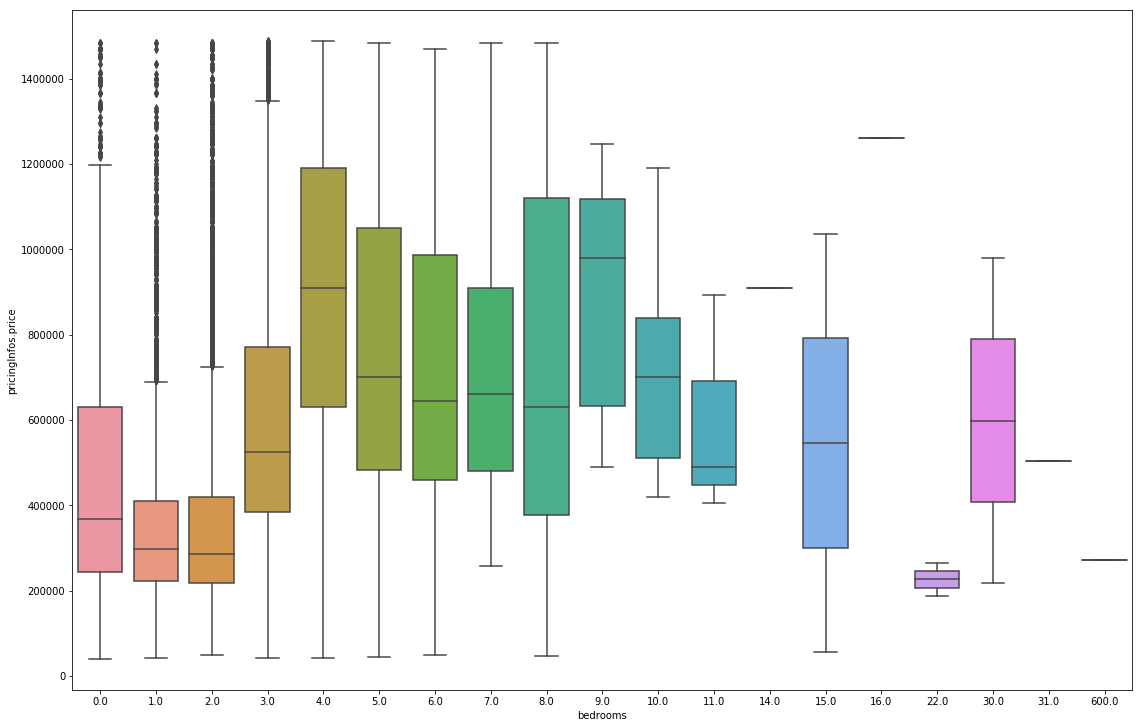

In [24]:
fig=plt.figure(figsize=(19,12.5))
sns.boxplot(x=df['bedrooms'], y=df['pricingInfos.price'])

Verifica-se outliers de 600 quartos. Assim optou-se por um corte acima de 20 quartos e pelos menos 1

In [25]:

df.drop(df[df['bedrooms']>20].index, axis=0, inplace=True)

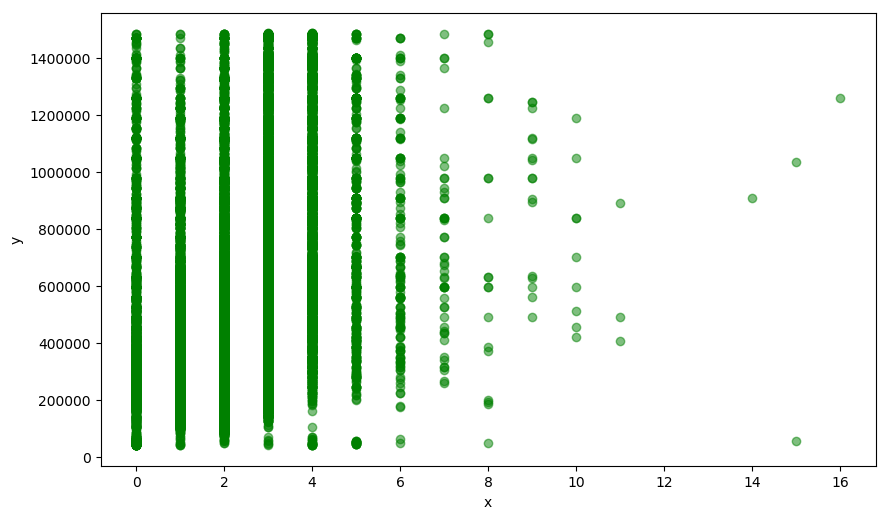

In [26]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['bedrooms'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

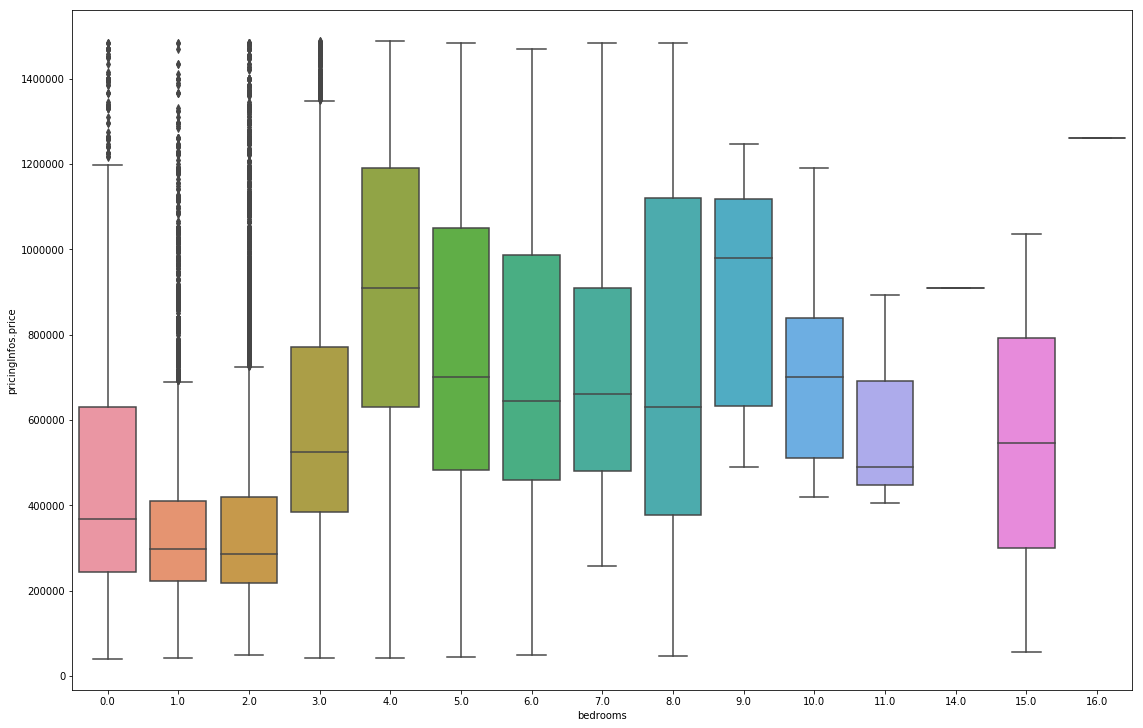

In [27]:
fig=plt.figure(figsize=(19,12.5))
sns.boxplot(x=df['bedrooms'], y=df['pricingInfos.price'])

#### 5.4 ParkingSpaces

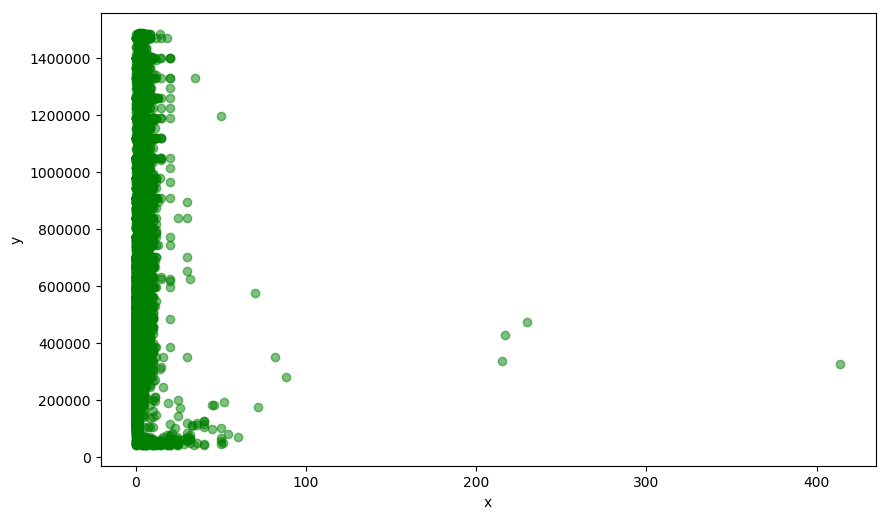

In [28]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['parkingSpaces'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

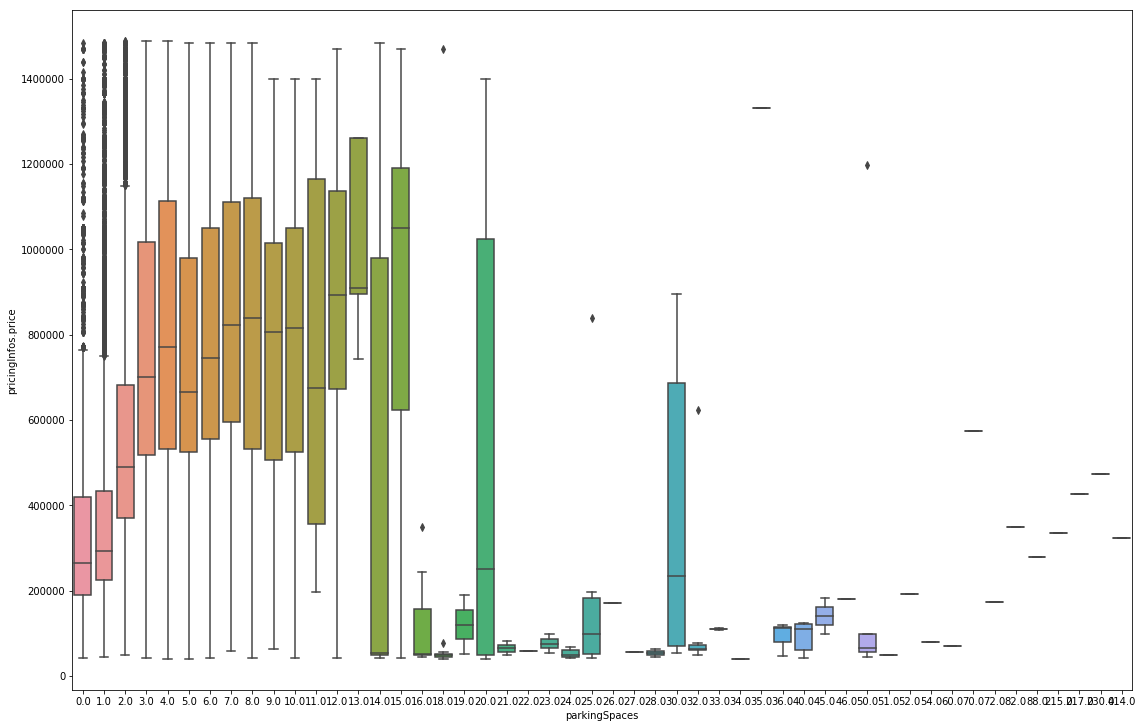

In [29]:
fig=plt.figure(figsize=(19,12.5))
sns.boxplot(x=df['parkingSpaces'], y=df['pricingInfos.price'])

De uma maneira geral a média de preço dos imóveis cresce à medida que aumenta o número de vagas para até 15 vagas, a partir disso a relação se distorce. Assim sendo optou-se por cortar os dados para 15 vagas:

In [30]:

df.drop(df[df['parkingSpaces']>15].index, axis=0, inplace=True)

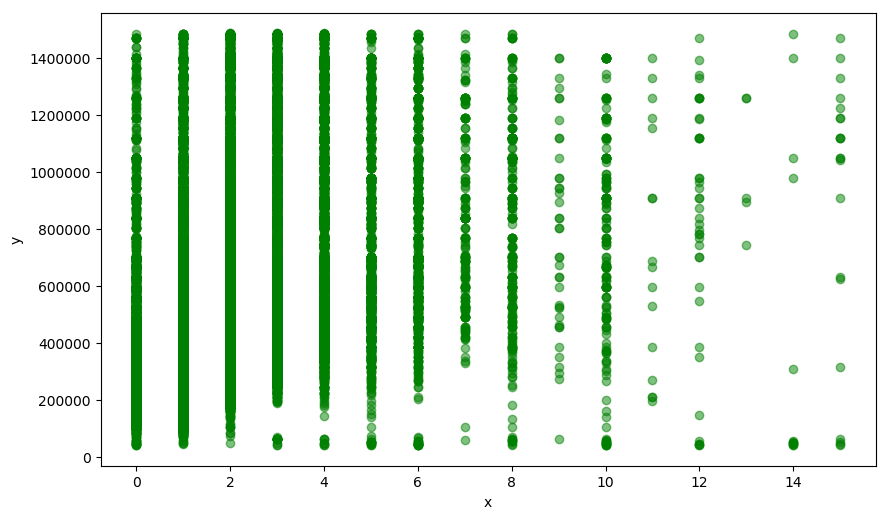

In [31]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['parkingSpaces'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

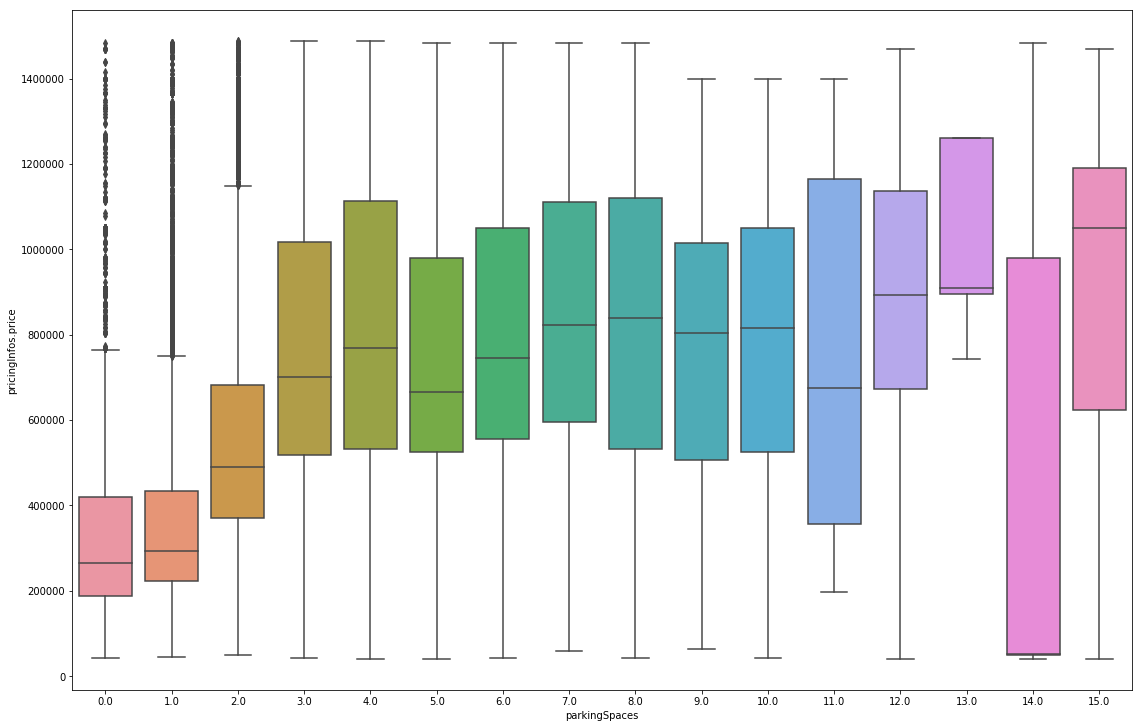

In [32]:
fig=plt.figure(figsize=(19,12.5))
sns.boxplot(x=df['parkingSpaces'], y=df['pricingInfos.price'])

#### 5.5 PricingInfos.monthlyCondoFee

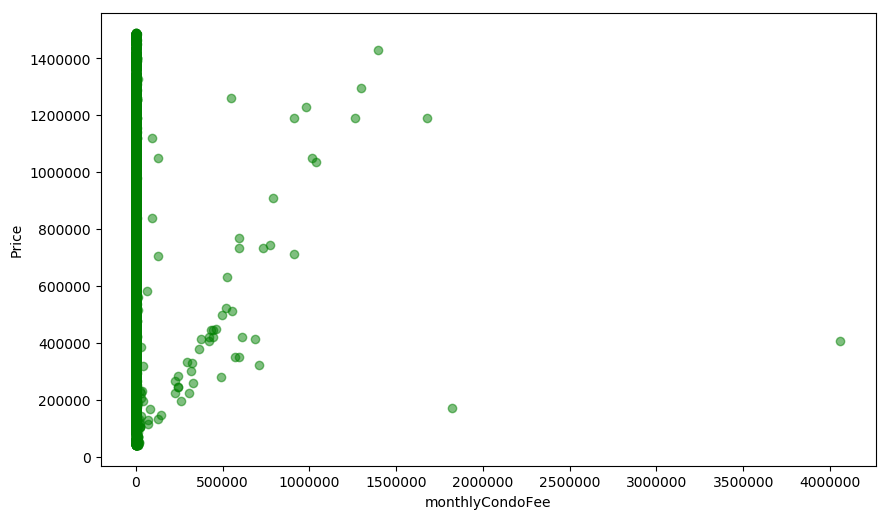

In [36]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['pricingInfos.monthlyCondoFee'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('monthlyCondoFee')
plt.ylabel('Price')
plt.show()

In [37]:
df['pricingInfos.monthlyCondoFee'].describe()

count    7.569400e+04
mean     8.817208e+02
std      2.328985e+04
min      0.000000e+00
25%      0.000000e+00
50%      3.360000e+02
75%      6.300000e+02
max      4.059999e+06
Name: pricingInfos.monthlyCondoFee, dtype: float64

In [38]:
df.drop(df[df['pricingInfos.monthlyCondoFee']>3000].index, axis=0, inplace=True)

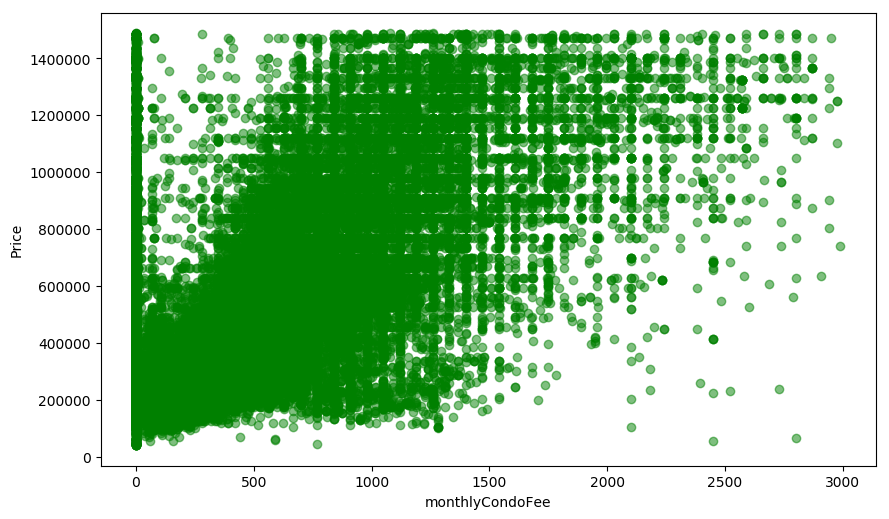

In [39]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['pricingInfos.monthlyCondoFee'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('monthlyCondoFee')
plt.ylabel('Price')
plt.show()

#### 5.6 PricingInfos.yearlyIptu

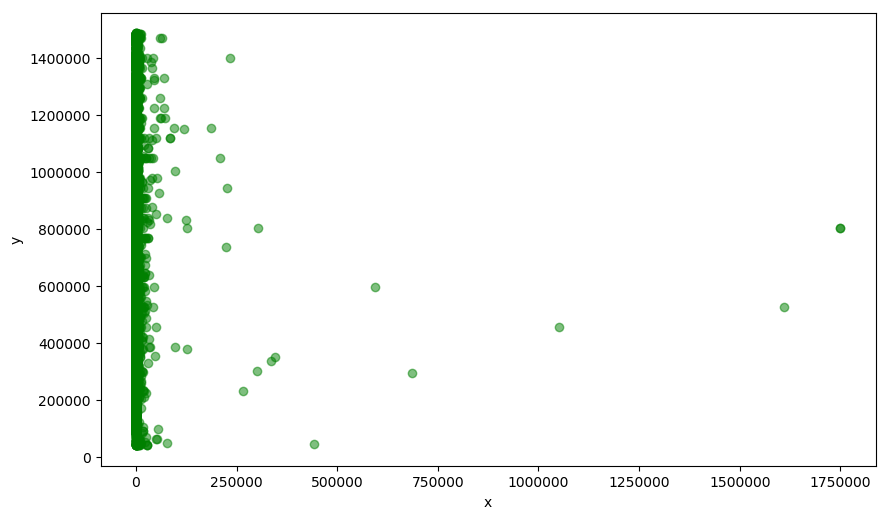

In [40]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['pricingInfos.yearlyIptu'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [41]:
df['pricingInfos.yearlyIptu'].describe()

count    7.103400e+04
mean     4.617333e+02
std      1.290893e+04
min      0.000000e+00
25%      0.000000e+00
50%      3.500000e+01
75%      2.030000e+02
max      1.750000e+06
Name: pricingInfos.yearlyIptu, dtype: float64

In [42]:
df.drop(df[df['pricingInfos.yearlyIptu']<100].index, axis=0, inplace=True)
df.drop(df[df['pricingInfos.yearlyIptu']>30000].index, axis=0, inplace=True)

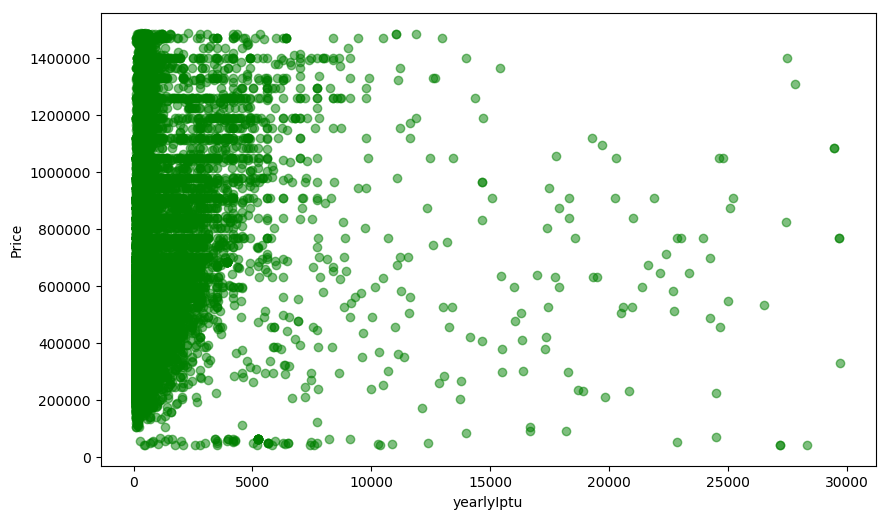

In [43]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['pricingInfos.yearlyIptu'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('yearlyIptu')
plt.ylabel('Price')
plt.show()

#### 5.7 Suits

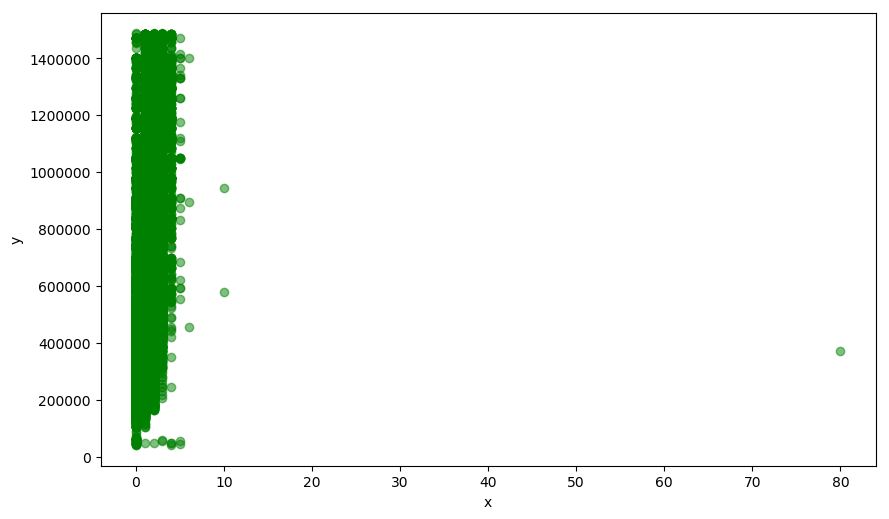

In [44]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['suites'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

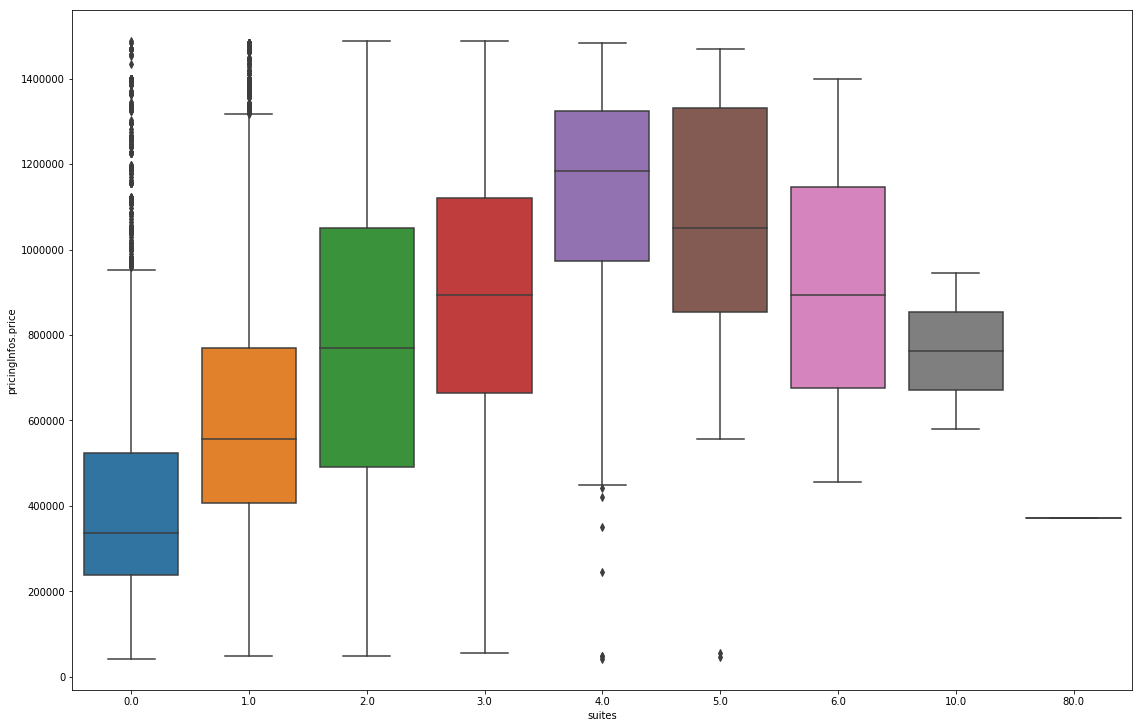

In [45]:
fig=plt.figure(figsize=(19,12.5))
sns.boxplot(x=df['suites'], y=df['pricingInfos.price'])

Pelo gráfico a média de preço dos imóveis cresce à medida que aumenta o número de suítes para até 5 suítes, a partir disso decresce. Como os dados são poucos para 6 ou mais suítes optou-se por cortar o dataset para até 5:

In [46]:
df.drop(df[df['suites']>5].index, axis=0, inplace=True)

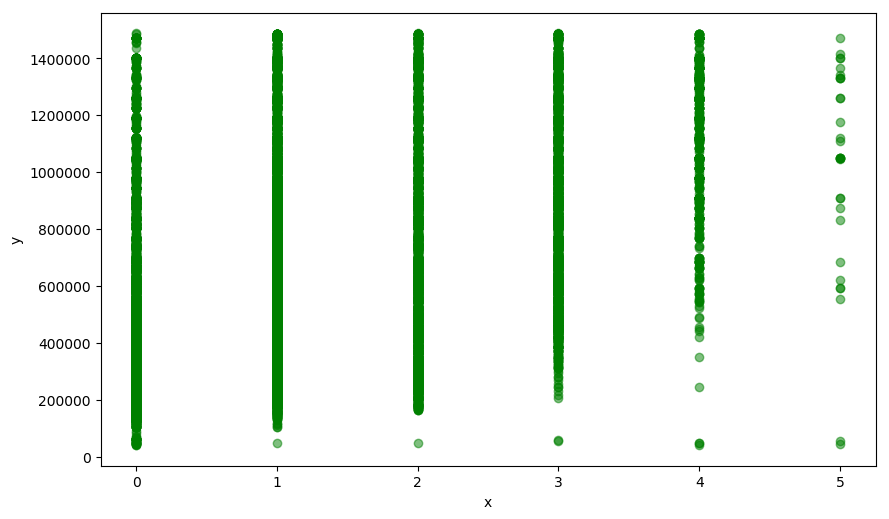

In [47]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['suites'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

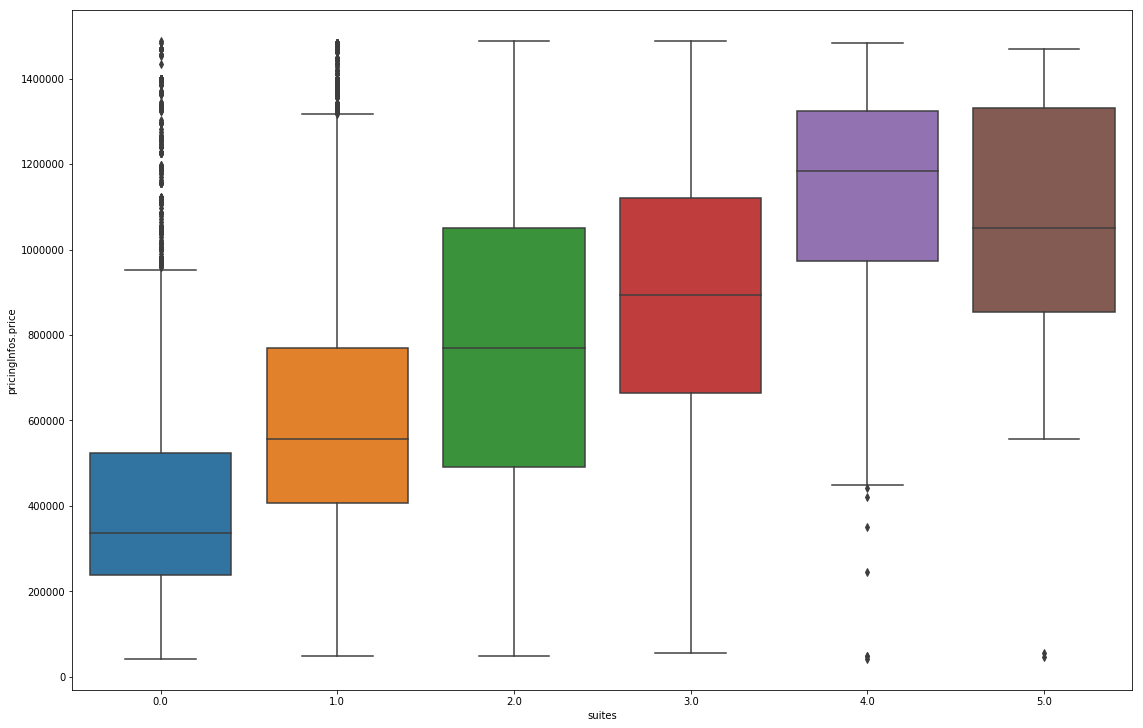

In [48]:
fig=plt.figure(figsize=(19,12.5))
sns.boxplot(x=df['suites'], y=df['pricingInfos.price'])

#### 5.8 TotalAreas

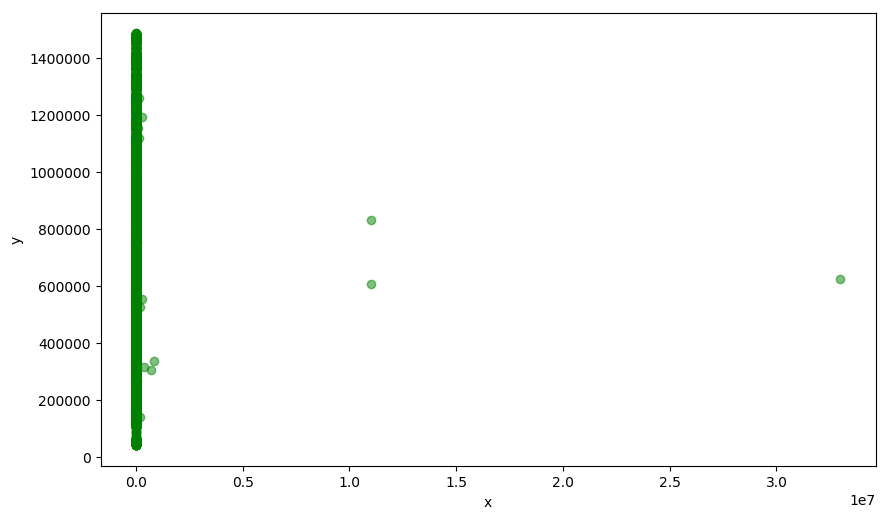

In [49]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['totalAreas'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [50]:
df['totalAreas'].describe()

count    2.602100e+04
mean     2.439326e+03
std      2.263034e+05
min      0.000000e+00
25%      7.200000e+01
50%      1.250000e+02
75%      2.000000e+02
max      3.300000e+07
Name: totalAreas, dtype: float64

In [51]:
df.drop(df[df['totalAreas']<10].index, axis=0, inplace=True)
df.drop(df[df['totalAreas']>1000].index, axis=0, inplace=True)

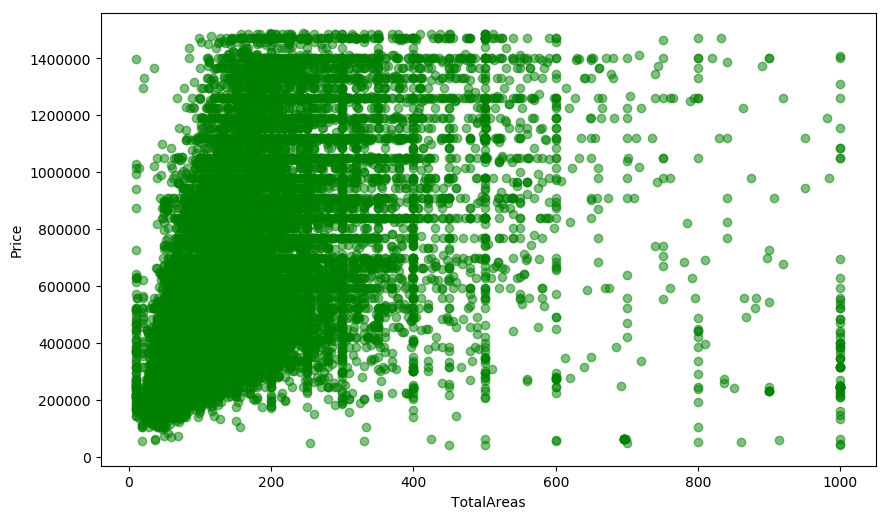

In [52]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['totalAreas'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('TotalAreas')
plt.ylabel('Price')
plt.show()

#### 5.9 UsableAreas

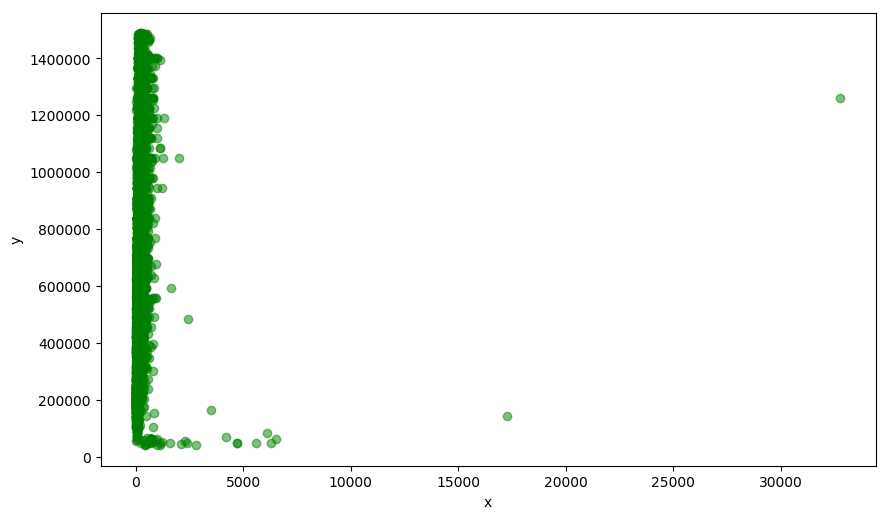

In [53]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['usableAreas'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [54]:
df.drop(df[df['usableAreas']<10].index, axis=0, inplace=True)
df.drop(df[df['usableAreas']>1000].index, axis=0, inplace=True)

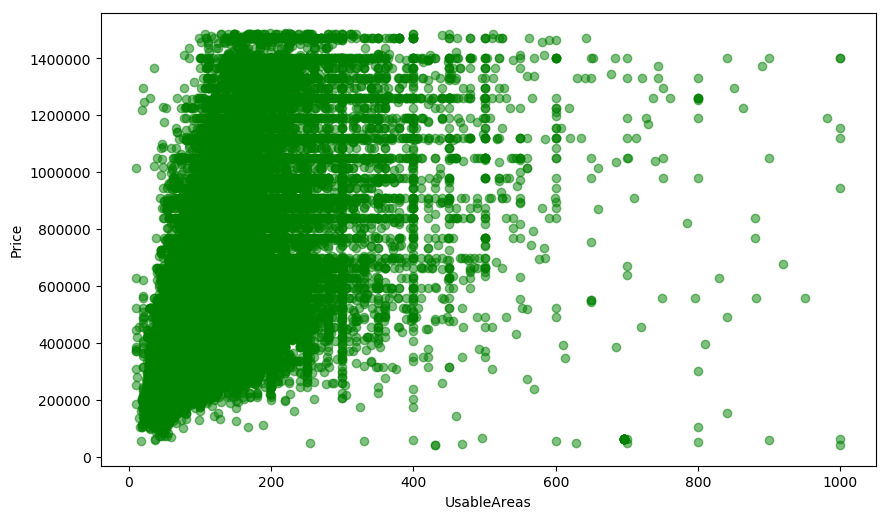

In [55]:
fig = plt.figure(figsize=(10,6), dpi=100)
plt.scatter(df['usableAreas'], df['pricingInfos.price'] , c='g', alpha=0.5)
#plt.title('Scatter plot pythonspot.com')
plt.xlabel('UsableAreas')
plt.ylabel('Price')
plt.show()

### 6. Preenchendo os dados que faltam com as médias por bairros e tipo dos imóveis

In [59]:

df['bathrooms'] = df.groupby(['unitTypes','address.neighborhood'])['bathrooms']\
    .transform(lambda x: x.fillna(x.mean()))

In [60]:
df['bedrooms'] = df.groupby(['unitTypes','address.neighborhood'])['bedrooms']\
    .transform(lambda x: x.fillna(x.mean()))

In [61]:
df['parkingSpaces'] = df.groupby(['unitTypes','address.neighborhood'])['parkingSpaces']\
    .transform(lambda x: x.fillna(x.mean()))

In [62]:
df['pricingInfos.monthlyCondoFee'] = df.groupby(['unitTypes','address.neighborhood'])['pricingInfos.monthlyCondoFee']\
    .transform(lambda x: x.fillna(x.mean()))

In [63]:
df['pricingInfos.yearlyIptu'] = df.groupby(['unitTypes','address.neighborhood'])['pricingInfos.yearlyIptu']\
    .transform(lambda x: x.fillna(x.mean()))

In [64]:
df['suites'] = df.groupby(['unitTypes','address.neighborhood'])['suites']\
    .transform(lambda x: x.fillna(x.mean()))

In [65]:
df['totalAreas'] = df.groupby(['unitTypes','address.neighborhood'])['totalAreas']\
    .transform(lambda x: x.fillna(x.mean()))

In [66]:
df['usableAreas'] = df.groupby(['unitTypes','address.neighborhood'])['usableAreas']\
    .transform(lambda x: x.fillna(x.mean()))

In [67]:
#preenchendo o restante com a média total por colunas
df1=df.fillna(df.mean())

In [68]:
#verificando dados faltando por coluna
df1.isnull().sum()

address.geoLocation.precision    0
address.neighborhood             0
address.street                   0
bathrooms                        0
bedrooms                         0
parkingSpaces                    0
pricingInfos.monthlyCondoFee     0
pricingInfos.price               0
pricingInfos.yearlyIptu          0
suites                           0
totalAreas                       0
unitTypes                        0
usableAreas                      0
dtype: int64

In [ ]:
#df1=df.dropna(axis=0)

Abaixo verifica-se como fica a correlação entre as variáveis após a eliminação de outliers

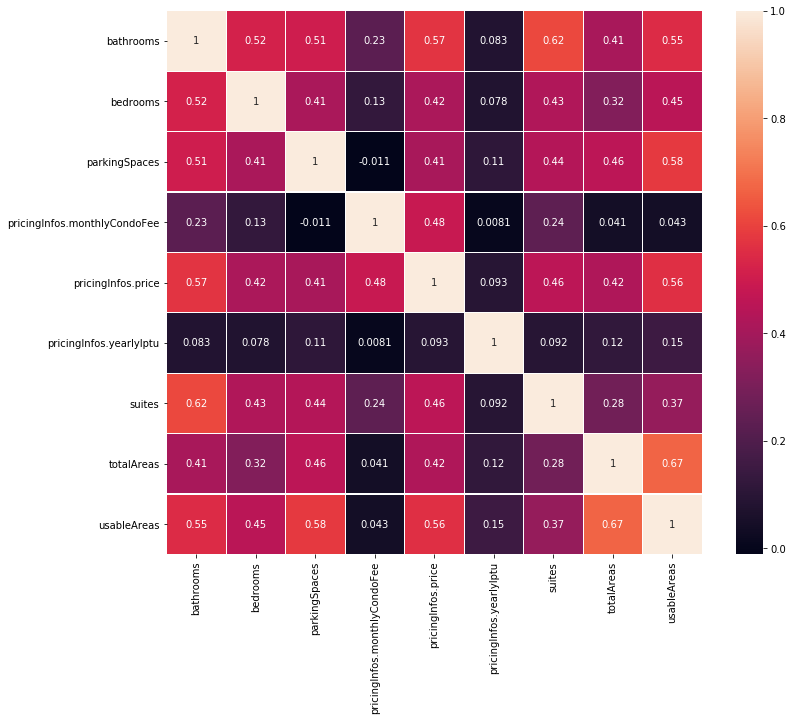

In [69]:
#correration matrix

plt.figure(figsize=(12,10))
sns.heatmap(df1.corr(),linewidths=0.1,annot=True)

Observe que após o tratamento de outliers o mapa de calor mudou. Agora, o preço dos imóveis se correlaciona melhor com o número de banheiros, tamanho do imóvel e condomínio.


### 7. Convertendo variáveis categóricas em numéricas

As variáveis categóricas como Bairros, Nome das Ruas e Tipo do imóvel foram transformadas em variáveis numéricas para a aplicação do algoritmo Random Forest regressor.


In [71]:

cols = ('address.geoLocation.precision','address.neighborhood','address.street','unitTypes')
#aplicando LabelEncoder para as variáveis categóricas
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(df1[c].values))
    df1[c] = lbl.transform(list(df1[c].values))


In [72]:
df1.head()

,address.geoLocation.precision,address.neighborhood,address.street,bathrooms,bedrooms,parkingSpaces,pricingInfos.monthlyCondoFee,pricingInfos.price,pricingInfos.yearlyIptu,suites,totalAreas,unitTypes,usableAreas
0,4,514,4385,3.0,4.0,6.0,35.000000,700000,741.250000,1.0,388.0,17,388.0
1,3,1067,4377,2.0,3.0,2.0,570.682401,336000,676.333286,1.0,129.0,9,129.0
3,3,998,928,2.0,3.0,2.0,686.000000,739643,1610.000000,1.0,80.0,0,80.0
13,4,965,969,2.0,2.0,1.0,339.000000,332500,819.000000,0.0,69.0,0,69.0
15,1,694,1241,1.0,2.0,1.0,322.000000,193200,521.107143,0.0,50.0,0,50.0


In [73]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41175 entries, 0 to 133961
Data columns (total 13 columns):
address.geoLocation.precision    41175 non-null int64
address.neighborhood             41175 non-null int64
address.street                   41175 non-null int64
bathrooms                        41175 non-null float64
bedrooms                         41175 non-null float64
parkingSpaces                    41175 non-null float64
pricingInfos.monthlyCondoFee     41175 non-null float64
pricingInfos.price               41175 non-null int64
pricingInfos.yearlyIptu          41175 non-null float64
suites                           41175 non-null float64
totalAreas                       41175 non-null float64
unitTypes                        41175 non-null int64
usableAreas                      41175 non-null float64
dtypes: float64(8), int64(5)
memory usage: 4.4 MB


### 8.Treinando o modelo de Random Forest regressor.

Vamos agora começar a treinar o modelo de Random Forest regressor. Precisamos primeiro dividir nossos dados em uma matriz X que contém os recursos para treinar, e uma matriz y com a variável alvo, neste caso, a coluna Price. 

In [74]:
X = df1[['address.geoLocation.precision','address.neighborhood','address.street','bathrooms','bedrooms','parkingSpaces','pricingInfos.monthlyCondoFee','pricingInfos.yearlyIptu','suites','totalAreas','unitTypes','usableAreas']]
y = df1['pricingInfos.price']

#### 8.1 Separando dados de treino e teste

In [75]:
#dividindo entre dados de treino e teste:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#### 8.2 Criando e treinando o modelo

In [76]:
from sklearn.ensemble import RandomForestRegressor

In [77]:
rf = RandomForestRegressor(n_estimators=500,max_depth=7)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [78]:
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

Accuracy on training set: 0.723
Accuracy on test set: 0.690


Pelo score acima pode-se observar que o número de acertos para os dados de teste e treino foi próximo de 70%, número considerado como bom.

#### 8.3 Treinando o modelo com todos os dados

In [80]:
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [ ]:
#y = np.log1p(df1['pricingInfos.price'])

In [81]:
# testando com cross validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X, y,cv=10)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.70099799 0.62792397 0.69437259 0.69134224 0.71807204 0.68398908
 0.60123131 0.6920451  0.6661531  0.71451777]


### 9. Estimando os dados de teste

In [82]:
#abrindo json
with open('agoravai.json','r',encoding="utf8") as f:
    datateste = [json.loads(line) for line in f]

In [83]:
#convertendo em dataframe
from pandas.io.json import json_normalize
dfteste = pd.DataFrame.from_dict(json_normalize(datateste), orient='columns')

#### 9.1 Eliminando colunas que não serão utilizadas

In [84]:
dfteste.drop(['publicationType','pricingInfos.rentalTotalPrice','address.state','address.zone','address.city','address.streetNumber','address.geoLocation.location.lat','address.geoLocation.location.lon','address.country','address.district','address.locationId','address.unitNumber','address.zipCode','createdAt','description','updatedAt',
            'images','listingStatus','owner','pricingInfos.businessType','pricingInfos.period','publisherId','title'],axis=1,inplace=True)

In [85]:
dfteste.isnull().sum()

address.geoLocation.precision       3
address.neighborhood                0
address.street                      0
bathrooms                           1
bedrooms                            0
id                                  0
parkingSpaces                     264
pricingInfos.monthlyCondoFee      936
pricingInfos.price                  0
pricingInfos.yearlyIptu          2397
suites                           1395
totalAreas                       6094
unitTypes                           0
usableAreas                         7
dtype: int64

#### 9.2 Preenchendo dados que faltam 

In [86]:
dfteste['bathrooms'] = dfteste.groupby(['address.neighborhood'])['bathrooms']\
    .transform(lambda x: x.fillna(x.mean()))

In [87]:
dfteste['parkingSpaces'] = dfteste.groupby(['address.neighborhood'])['parkingSpaces']\
    .transform(lambda x: x.fillna(x.mean()))

In [88]:
dfteste['parkingSpaces'].fillna(0,inplace=True)

In [89]:
dfteste['pricingInfos.monthlyCondoFee'] = dfteste.groupby(['unitTypes','address.neighborhood'])['pricingInfos.monthlyCondoFee']\
    .transform(lambda x: x.fillna(x.mean()))

In [90]:
dfteste['pricingInfos.monthlyCondoFee'].fillna(dfteste['pricingInfos.monthlyCondoFee'].mean(),inplace=True)

In [91]:
dfteste['pricingInfos.yearlyIptu'] = dfteste.groupby(['unitTypes','address.neighborhood'])['pricingInfos.yearlyIptu']\
    .transform(lambda x: x.fillna(x.mean()))

In [92]:
dfteste['pricingInfos.yearlyIptu'].fillna(dfteste['pricingInfos.yearlyIptu'].mean(),inplace=True)

In [93]:
dfteste['suites'] = dfteste.groupby(['unitTypes','address.neighborhood'])['suites']\
    .transform(lambda x: x.fillna(x.mean()))

In [94]:
dfteste['suites'].fillna(dfteste['suites'].mean(),inplace=True)

In [95]:
dfteste['totalAreas'] = dfteste.groupby(['unitTypes','address.neighborhood'])['totalAreas']\
    .transform(lambda x: x.fillna(x.mean()))

In [96]:
dfteste['totalAreas'].fillna(dfteste['totalAreas'].mean(),inplace=True)

In [97]:
dfteste['usableAreas'] = dfteste.groupby(['unitTypes','address.neighborhood'])['usableAreas']\
    .transform(lambda x: x.fillna(x.mean()))

In [98]:
dfteste['address.geoLocation.precision'].fillna('None',inplace=True)

In [99]:
dfteste.isnull().sum()

address.geoLocation.precision    0
address.neighborhood             0
address.street                   0
bathrooms                        0
bedrooms                         0
id                               0
parkingSpaces                    0
pricingInfos.monthlyCondoFee     0
pricingInfos.price               0
pricingInfos.yearlyIptu          0
suites                           0
totalAreas                       0
unitTypes                        0
usableAreas                      0
dtype: int64

#### 9.3 Convertendo variáveis categóricas em numéricas

In [100]:
cols = ('address.geoLocation.precision','address.neighborhood','address.street','unitTypes')
#Aplicando LabelEncoder nas variáveis categóricas
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(dfteste[c].values))
    dfteste[c] = lbl.transform(list(dfteste[c].values))


#### 9.4 Separando as colunas para fazer a predição

In [101]:
X_teste = dfteste[['address.geoLocation.precision','address.neighborhood','address.street','bathrooms','bedrooms','parkingSpaces','pricingInfos.monthlyCondoFee','pricingInfos.yearlyIptu','suites','totalAreas','unitTypes','usableAreas']]


#### 9.5 Fazendo a predição dos preços dos imóveis

In [102]:
pred=rf.predict(X_teste)

In [103]:
pred

array([ 429813.84321985,  215362.81159808,  579756.52156096, ...,
        434380.03204787,  558717.99542382, 1243320.7703267 ])

#### 9.6 Convertendo os resultados em arquivo csv com duas colunas "id" e "price"

In [104]:
dfteste['pricingInfos.price']=pred

In [105]:
dfteste.head()

,address.geoLocation.precision,address.neighborhood,address.street,bathrooms,bedrooms,id,parkingSpaces,pricingInfos.monthlyCondoFee,pricingInfos.price,pricingInfos.yearlyIptu,suites,totalAreas,unitTypes,usableAreas
0,1,116,807,1.0,1,89224365f8,1.0,1027.416327,429813.843220,850.008658,0.0,47.0,0,47.0
1,5,477,868,0.0,2,363731333f,1.0,0.000000,215362.811598,0.000000,0.0,55.0,0,55.0
2,5,61,1049,3.0,3,6e6283378a,2.0,686.000000,579756.521561,237.972222,1.0,97.6,0,92.0
3,1,28,1626,4.0,3,4c29a27f44,3.0,770.000000,908378.831598,368.000000,3.0,145.0,0,145.0
4,5,10,2458,2.0,2,7b16cf224b,1.0,472.000000,549431.277231,79.000000,1.0,76.0,0,76.0


In [106]:
dffinal=dfteste.drop(['address.geoLocation.precision','address.neighborhood','address.street','bathrooms','bedrooms','parkingSpaces','pricingInfos.monthlyCondoFee','pricingInfos.yearlyIptu','suites','totalAreas','unitTypes','usableAreas'],axis=1)

In [107]:
dffinal.columns = ['id', 'price']

In [108]:
dffinal.head()

,id,price
0,89224365f8,429813.843220
1,363731333f,215362.811598
2,6e6283378a,579756.521561
3,4c29a27f44,908378.831598
4,7b16cf224b,549431.277231


In [109]:
dffinal.to_csv('Price.csv',index=False)

# The End - That's all Folks